<a href="https://colab.research.google.com/github/palkop11/soh-ml/blob/master/interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
# so you can upload DATA from drive
# to colab environment

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# clone repo
# works when repo is public

!git clone https://github.com/palkop11/soh-ml.git

# jump to repo directory

%cd soh-ml

Cloning into 'soh-ml'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 98 (delta 52), reused 75 (delta 41), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 1.00 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/soh-ml


In [19]:
# upload dataset_v5_npz.zip anywhere in google drive
# find it and then extract it into temporary workspace

!find /content/drive -name "dataset_v5_ts_npz.zip" | xargs -I {} unzip -qo {} -d "./DATA/"
!find /content/soh-ml/DATA -maxdepth 1

/content/soh-ml/DATA
/content/soh-ml/DATA/dataset_v5_ts_npz


In [21]:
"""
here should be pip install from requirements_colab for reproducibility
but now it only gives errors while installing and imports :/
!pip install -r requirements_colab.txt -q
"""

!pip install tensorboard tbparse pytorch-lightning lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#%cd soh-ml

/content/soh-ml


In [4]:
import learning

from lightning import seed_everything
seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | UnifiedBatteryModel | 51     | train
1 | loss_fn       | HuberLoss           | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | val_metrics   | MetricCollection    | 0      | train
4 | test_metrics  | MetricCollection    | 0      | train
--------------------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


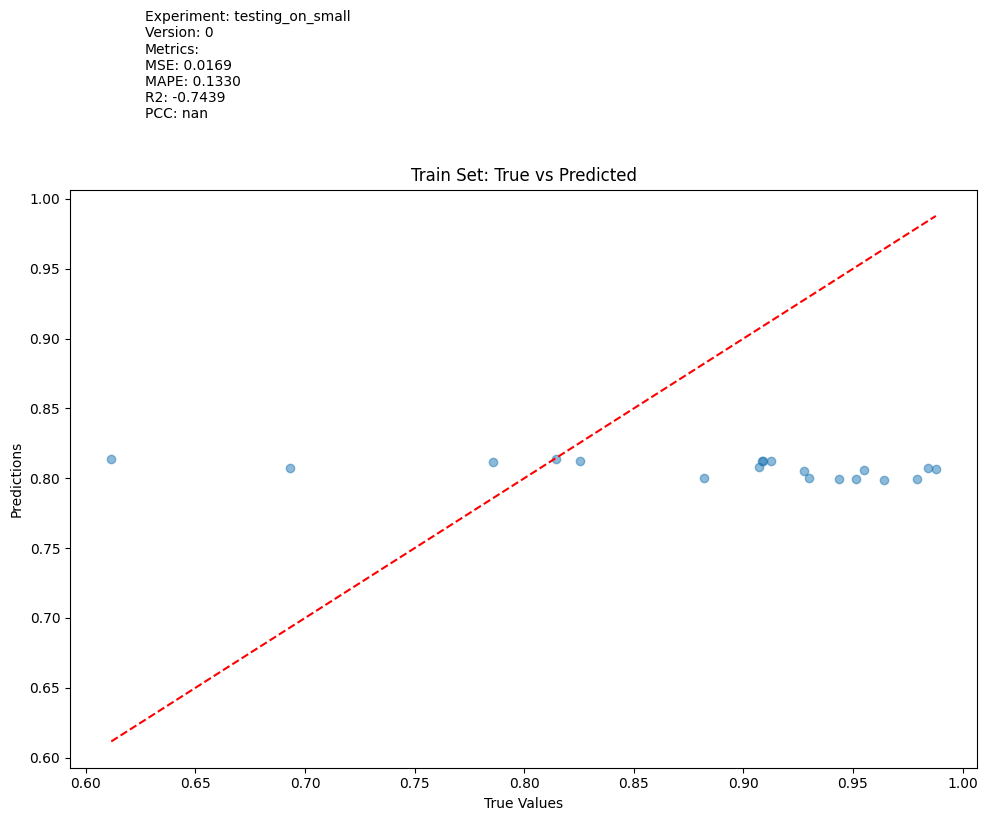

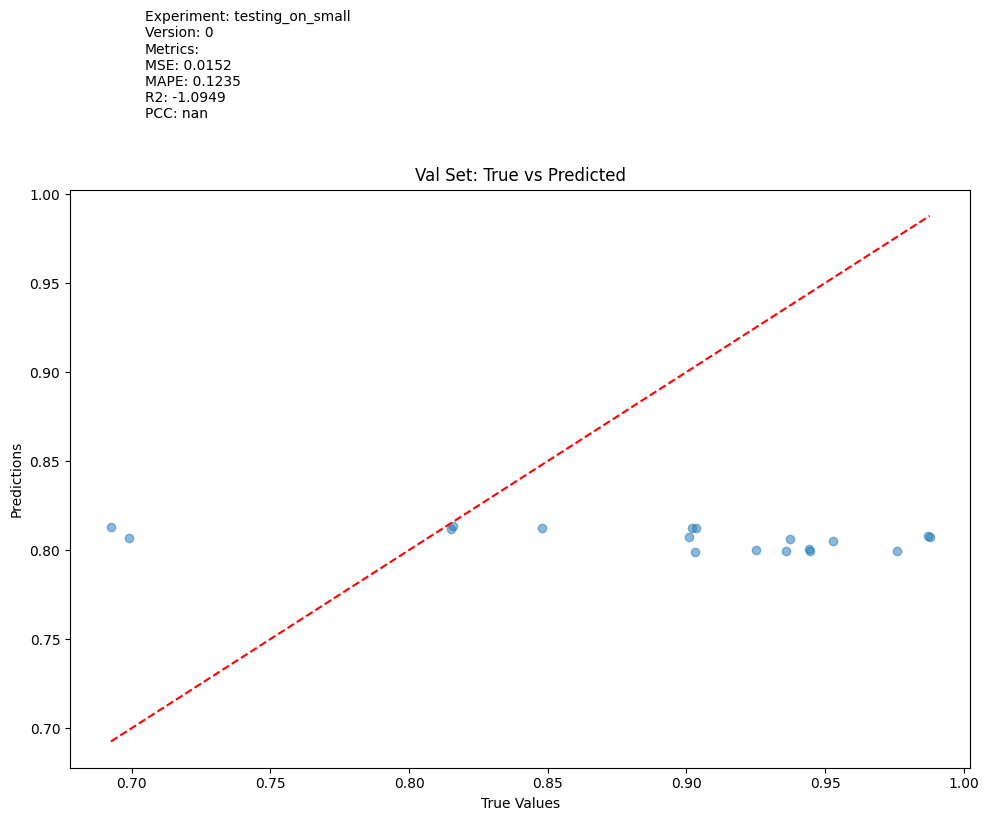

metrics on train:


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.05973028019070625    │
│         val_mape          │    0.13298825919628143    │
│          val_mse          │   0.016909148544073105    │
│          val_pcc          │            nan            │
│          val_r2           │    -0.7439202070236206    │
└───────────────────────────┴───────────────────────────┘

metrics on val:


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.0537751130759716     │
│         val_mape          │    0.12347012013196945    │
│          val_mse          │   0.015223287977278233    │
│          val_pcc          │            nan            │
│          val_r2           │    -1.0949134826660156    │
└───────────────────────────┴───────────────────────────┘

In [24]:
# you can use run_experiment to run
# pass learning.DEFAULT_CONFIG to use default config
# or you can specify your own dictionary and run experiment using it
# also you can pass PATH to config in .yaml format
learning.run_experiment(learning.DEFAULT_CONFIG)

In [ ]:
# or you can run !python learning.py with default_config
# you can specify config using !python learning.py --config /path/to/config.yaml

!python learning.py

Using default configuration
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-22 17:50:19.675851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747936220.069498   10282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747936220.191445   10282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-22 17:50:21.005755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate co

In [25]:
learning.DEFAULT_CONFIG

{'experiment_name': 'testing_on_small',
 'seed': 42,
 'data': {'datadir': './DATA/dataset_v5_ts_npz/',
  'train': ['small_NMC15', 'small_NMC11', 'small_LFP5', 'small_LFP8'],
  'val': ['small_NMC10', 'small_NMC14', 'small_LFP4', 'small_LFP1'],
  'normalization': {'x': None, 'y': 'minmax_zero_one'},
  'n_diff': 0},
 'model': {'input_size': 2,
  'cnn_hidden': 32,
  'lstm_hidden_size': 2,
  'num_layers': 1,
  'output_size': 1,
  'dropout': 0.0,
  'regressor_hidden_dim': None,
  'output_activation': 'sigmoid'},
 'resume_ckpt': 'auto',
 'loss_type': 'huber',
 'training': {'batch_size': 8,
  'learning_rate': 0.001,
  'epochs': 2,
  'accelerator': 'auto',
  'devices': 1},
 'logging': {'log_dir': './LOGS', 'progress_bar': True}}

In [5]:
config_1 = {
    'experiment_name': 'testing_on_small', # also used for TensorBoard logging
    'seed': 42,

    'data': {
        'datadir':'./DATA/dataset_v5_ts_npz/',
        'train': ['small_NMC15', 'small_NMC11', 'small_LFP5', 'small_LFP8'],
        'val': ['small_NMC10', 'small_NMC14', 'small_LFP4', 'small_LFP1'],
        #'test': None, # comment this line if you do not pass test dataset
        'normalization': {'x': None, 'y': 'minmax_zero_one'},
        'n_diff': 0,
    },

    'model': {
        'input_size': 2,
        'cnn_hidden': 32,
        'lstm_hidden_size': 32,
        'num_layers': 1,
        'output_size': 1,
        'dropout': 0.,
        'regressor_hidden_dim': None,
        'output_activation': 'sigmoid',
    },

    'resume_ckpt': None,
    'loss_type': 'huber',

    'training': {
        'batch_size': 32,
        'learning_rate': 1e-3,
        'epochs': 5,
        'accelerator': 'auto',
        'devices': 1,
    },

    'logging': {
        'log_dir': './LOGS',
        'progress_bar': True,
    }
}